# ONNX predictions (Image Classification)

In [1]:
import json
import onnxruntime
import glob
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

## Azure ML workspace

In [3]:
your_azure_id = "tobereplaced"
your_azureml_workspace_resourcegroup = "tobereplaced"
your_azurelml_workspace = "tobereplaced"

subscription_id = os.environ.get("SUBSCRIPTION_ID", your_azure_id)
resource_group = os.environ.get("RESOURCE_GROUP", your_azureml_workspace_resourcegroup)
workspace_name = os.environ.get("WORKSPACE_NAME", your_azurelml_workspace)

In [4]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, 
                   resource_group = resource_group, 
                   workspace_name = workspace_name)
    ws.write_config()
    print("[OK] Workspace configuration saved.")

except:
    print("[Error] Workspace not found!")

[OK] Workspace configuration saved.


In [5]:
try:
    print("Loading Azure ML workspace config...")
    ws = Workspace.from_config()
    # ws.get_details()
    print("\n[OK] Workspace is available:")
    print("Azure ML workspace:", ws.name)
    print("Azure ML resource group:", ws.resource_group)

except:
    print("[Error] Cannot load configuration")

Loading Azure ML workspace config...

[OK] Workspace is available:
Azure ML workspace: azuremlvision
Azure ML resource group: azuremlvision-rg


## Azure ML Experiment

In [6]:
from azureml.core import Experiment

experiment_name = "AutomlforImages-FlowersClassification"
experiment = Experiment(ws, name=experiment_name)

In [7]:
experiment

Name,Workspace,Report Page,Docs Page
AutomlforImages-FlowersClassification,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [8]:
from azureml.train.automl.run import AutoMLRun

run_id = 'AutoML_e291725e-a517-43f3-96f4-a7922cbd8d7d' # Specify the run ID of your Azure AutoML
automl_image_run = AutoMLRun(experiment=experiment, run_id=run_id)
best_child_run = automl_image_run.get_best_child()

## Downloading the labels & ONNX files

In [9]:
# Downloading the labels & onnx file
labels_file = 'automl_models/labels.json'
best_child_run.download_file(name='train_artifacts/labels.json', output_file_path=labels_file)

onnx_model_path = 'automl_models/model.onnx'
best_child_run.download_file(name='train_artifacts/model.onnx', output_file_path=onnx_model_path)

In [10]:
!ls automl_models/*.* -lh

-rwxrwxrwx 1 root root   55 Jul 27 07:55 automl_models/labels.json
-rwxrwxrwx 1 root root 328M Jul 27 07:55 automl_models/model.onnx


In [11]:
# Printing labels
labels_file = "automl_models/labels.json"

with open(labels_file) as f:
    classes = json.load(f)

print("Classes:", classes)
print("Number of classes =", len(classes))

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of classes = 5


## Starting ONNX session

In [12]:
# Onnx Session
try:
    session = onnxruntime.InferenceSession(onnx_model_path)
    print("ONNX model loaded...")
except Exception as e: 
    print("Error loading ONNX file: ",str(e))

sess_input = session.get_inputs()
sess_output = session.get_outputs()

print(f"No. of inputs : {len(sess_input)}, No. of outputs : {len(sess_output)}")

ONNX model loaded...
No. of inputs : 1, No. of outputs : 1


In [13]:
for idx, input_ in enumerate(range(len(sess_input))):
    input_name = sess_input[input_].name
    input_shape = sess_input[input_].shape
    input_type = sess_input[input_].type
    print(f"{idx} Input name : { input_name }, Input shape : {input_shape}, \
    Input type  : {input_type}")  

for idx, output in enumerate(range(len(sess_output))):
    output_name = sess_output[output].name
    output_shape = sess_output[output].shape
    output_type = sess_output[output].type
    print(f" {idx} Output name : {output_name}, Output shape : {output_shape}, \
    Output type  : {output_type}")

batch, channel, height_onnx_crop_size, width_onnx_crop_size = session.get_inputs()[0].shape
batch, channel, height_onnx_crop_size, width_onnx_crop_size

0 Input name : input1, Input shape : ['batch', 3, 224, 224],     Input type  : tensor(float)
 0 Output name : output1, Output shape : ['batch', 5],     Output type  : tensor(float)


('batch', 3, 224, 224)

In [14]:
def _make_3d_tensor(x) -> torch.Tensor:
    """This function is for images that have less channels.

    :param x: input tensor
    :type x: torch.Tensor
    :return: return a tensor with the correct number of channels
    :rtype: torch.Tensor
    """
    return x if x.shape[0] == 3 else x.expand((3, x.shape[1], x.shape[2]))

def preprocess(image, resize_size, crop_size_onnx):
    transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size_onnx),
        transforms.ToTensor(),
        transforms.Lambda(_make_3d_tensor),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img_data = transform(image)
    img_data = img_data.numpy()
    img_data = np.expand_dims(img_data, axis=0)
    
    return img_data

## Testing the ONNX session with images from a test directory

In [20]:
test_images_path = "flowers-images/onnxtest/*" # replace with path to images !!!

In [22]:
!ls flowers-images/onnxtest/*.* -lh

-rwxrwxrwx 1 root root 174K Jul 27 07:52 'flowers-images/onnxtest/test (1).jpg'
-rwxrwxrwx 1 root root  54K Jul 27 07:52 'flowers-images/onnxtest/test (2).jpg'
-rwxrwxrwx 1 root root  21K Jul 27 07:52 'flowers-images/onnxtest/test (3).jpg'


In [23]:
# following code loads only batch_size number of images for demonstrating ONNX inference
# make sure that the data directory has at least batch_size number of images

# Select batch size needed
batch_size = 3

# you can modify resize_size based on your trained model
resize_size = 224

# height and width will be the same for classification
crop_size_onnx = height_onnx_crop_size 

image_files = glob.glob(test_images_path)
img_processed_list = []

i=0

while i < batch_size:
    img = Image.open(image_files[i])
    img_processed_list.append(preprocess(img, resize_size, crop_size_onnx))
    i += 1

if len(img_processed_list) > 1:
    img_data = np.concatenate(img_processed_list)

elif len(img_processed_list) == 1:
    img_data = img_processed_list[0]

else:
    img_data = None

assert batch_size == img_data.shape[0]

In [24]:
def get_predictions_from_ONNX(onnx_session, img_data):
    """Perform predictions with ONNX runtime
    
    :param onnx_session: onnx model session
    :type onnx_session: class InferenceSession
    :param img_data: pre-processed numpy image
    :type img_data: ndarray with shape 1xCxHxW
    :return: scores with shapes
            (1, No. of classes in training dataset) 
    :rtype: numpy array
    """

    sess_input = onnx_session.get_inputs()
    sess_output = onnx_session.get_outputs()
    print(f"No. of inputs : {len(sess_input)}, No. of outputs : {len(sess_output)}")    
    # predict with ONNX Runtime
    output_names = [ output.name for output in sess_output]
    scores = onnx_session.run(output_names=output_names,\
                                               input_feed={sess_input[0].name: img_data})
    
    return scores[0]

In [25]:
onnxscores = get_predictions_from_ONNX(session, img_data)

No. of inputs : 1, No. of outputs : 1


In [26]:
conf_scores = torch.nn.functional.softmax(torch.from_numpy(onnxscores), dim=1)
class_preds = torch.argmax(conf_scores, dim=1)

In [27]:
print("Predicted classes:\n", ([(class_idx.item(), classes[class_idx]) for class_idx in class_preds]))

Predicted classes:
 [(2, 'roses'), (4, 'tulips'), (0, 'daisy')]


## Viewing images with results

In [28]:
def results(sample_image_index):

    %matplotlib inline

    IMAGE_SIZE = (18, 12)
    plt.figure(figsize=IMAGE_SIZE)
    img_np = mpimg.imread(image_files[sample_image_index])

    img = Image.fromarray(img_np.astype('uint8'), 'RGB')
    x, y = img.size

    fig,ax = plt.subplots(1, figsize=(15, 15))
    # Display the image
    ax.imshow(img_np)

    label = class_preds[sample_image_index]
    if torch.is_tensor(label):
        label = label.item()
    
    conf_score = conf_scores[sample_image_index]
    if torch.is_tensor(conf_score):
        conf_score = np.max(conf_score.tolist())
    else:
        conf_score = np.max(conf_score)

    display_text = '{} ({})'.format(label, round(conf_score, 3))
    print(display_text)

    color = 'lime'
    plt.text(30, 30, display_text, color=color, fontsize=30)

    plt.show()

2 (0.986)


<Figure size 1296x864 with 0 Axes>

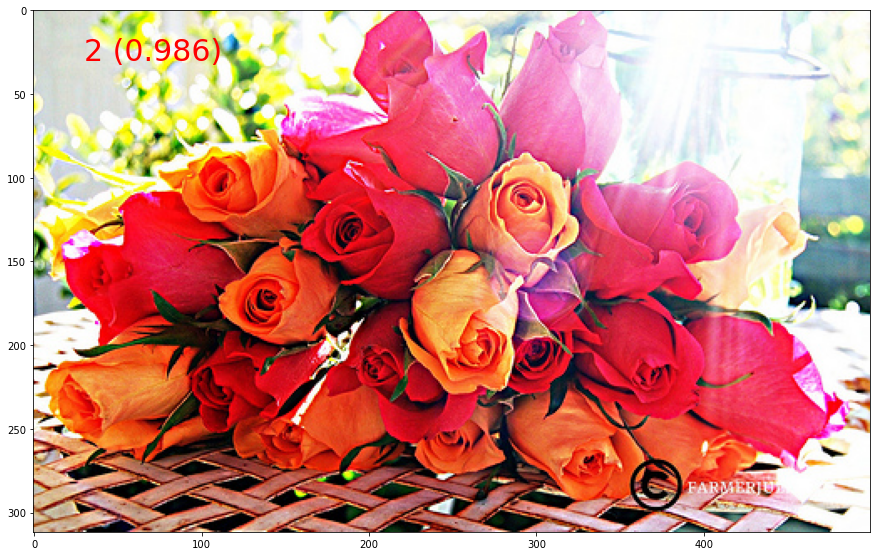

In [29]:
results(0)

4 (0.999)


<Figure size 1296x864 with 0 Axes>

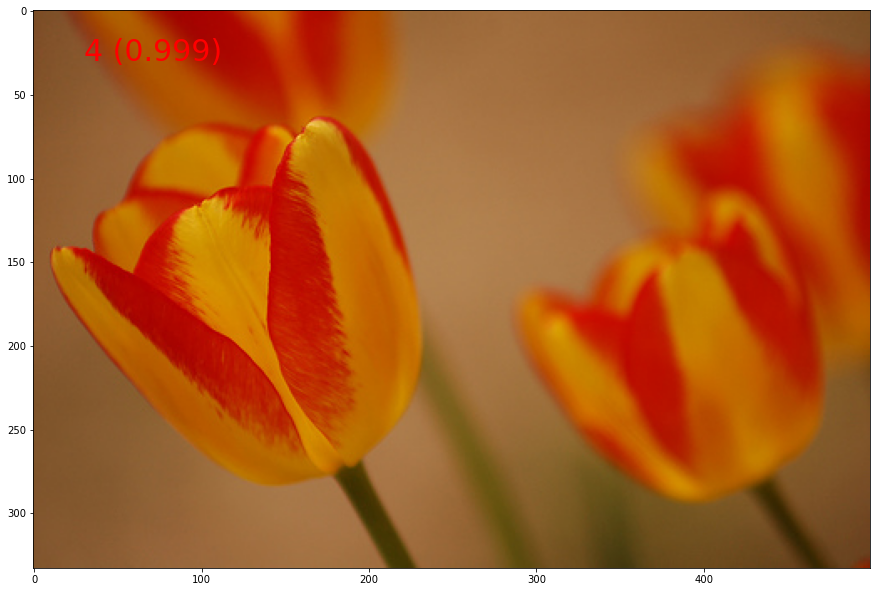

In [30]:
results(1)

0 (0.993)


<Figure size 1296x864 with 0 Axes>

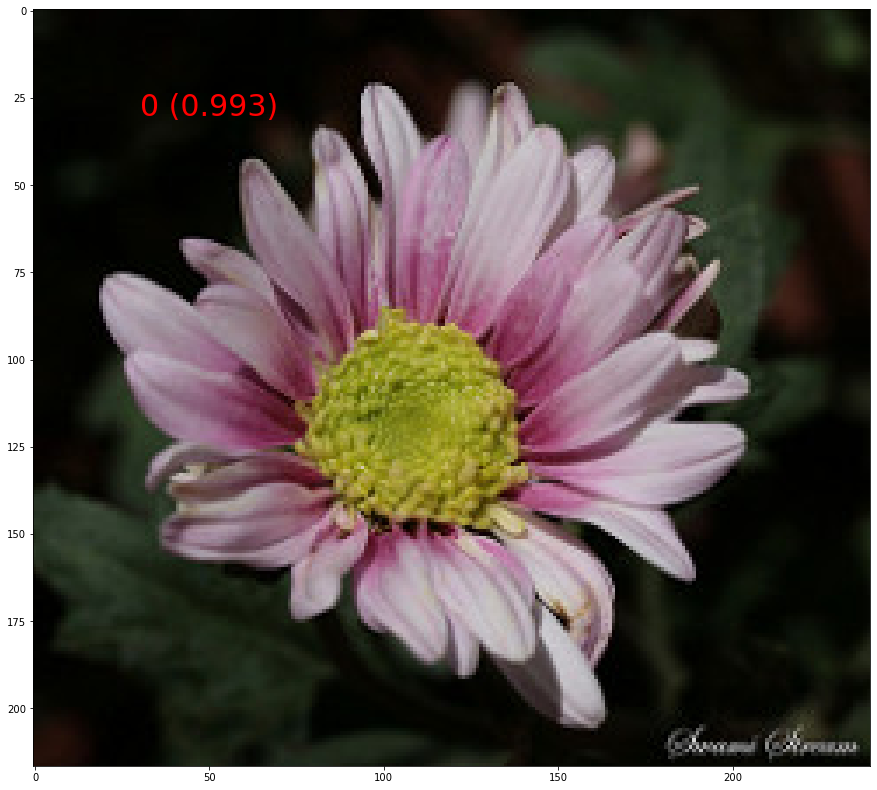

In [31]:
results(2)